#### Graphing yearly electricity and water growth for states

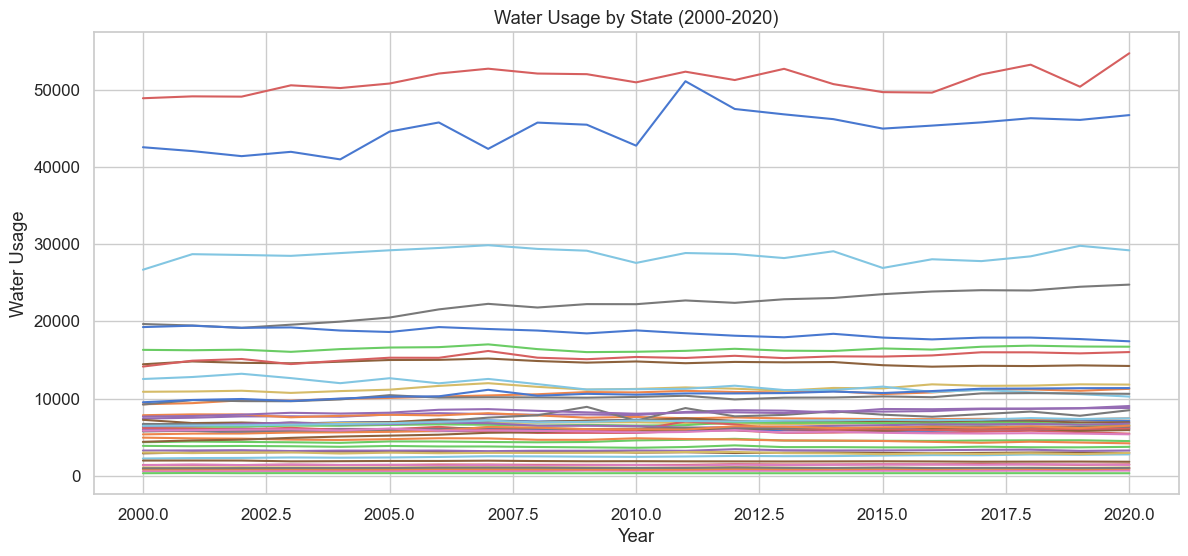

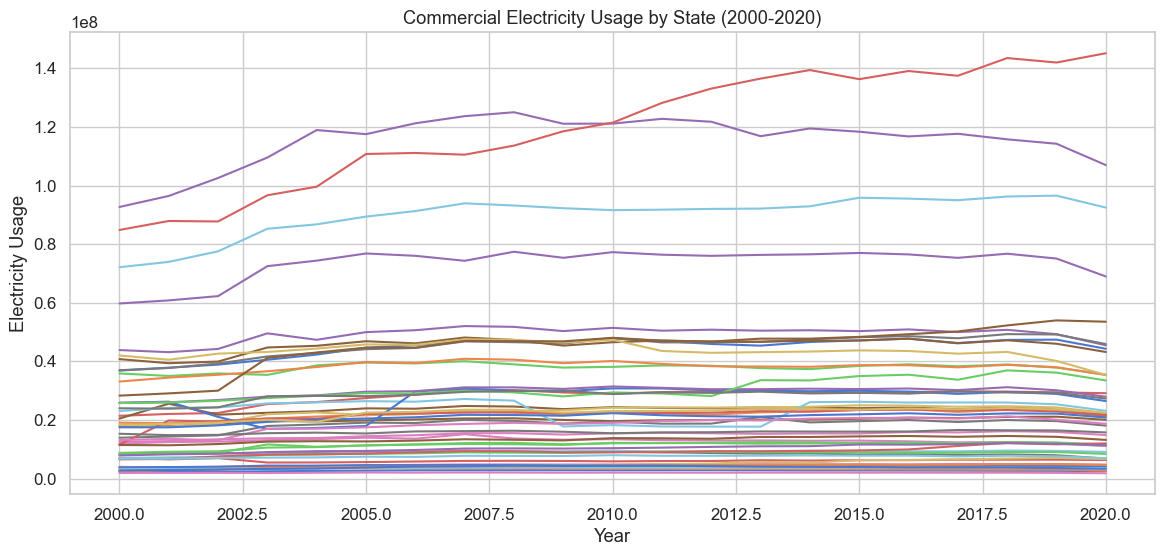

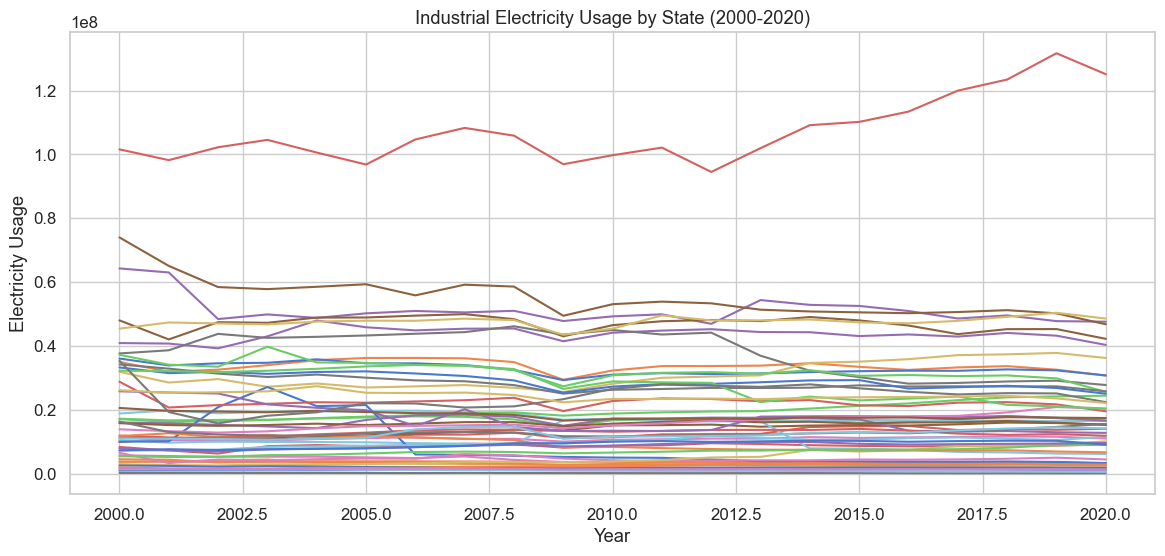

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data

water = pd.read_csv("../data/combined_water_data.csv")
electricity = pd.read_csv("../data/combined_electricity_data.csv")

# Filter electricity data -- commercial and industrial

electricity_com = electricity[
    (electricity['sector'] == 'Commercial') &
    (electricity['year'] >= 2000) &
    (electricity['year'] <= 2020)
]

electricity_ind = electricity[
    (electricity['sector'] == 'Industrial') &
    (electricity['year'] >= 2000) &
    (electricity['year'] <= 2020)
]


# Aggregate by State + year

water_state_year = water.groupby(['year', 'state'])['water_usage'].sum().reset_index()
elec_com_state_year = electricity_com.groupby(['year', 'state'])['electricity_usage'].sum().reset_index()
elec_ind_state_year = electricity_ind.groupby(['year', 'state'])['electricity_usage'].sum().reset_index()


# Plot water usage

plt.figure(figsize=(14,6))
for state in water_state_year['state'].unique():
    state_data = water_state_year[water_state_year['state'] == state]
    plt.plot(state_data['year'], state_data['water_usage'])
plt.title("Water Usage by State (2000-2020)")
plt.xlabel("Year")
plt.ylabel("Water Usage")
plt.show()


# Plot commercial electricity usage

plt.figure(figsize=(14,6))
for state in elec_com_state_year['state'].unique():
    state_data = elec_com_state_year[elec_com_state_year['state'] == state]
    plt.plot(state_data['year'], state_data['electricity_usage'])
plt.title("Commercial Electricity Usage by State (2000-2020)")
plt.xlabel("Year")
plt.ylabel("Electricity Usage")
plt.show()


# plot industrial electricity usage

plt.figure(figsize=(14,6))
for state in elec_ind_state_year['state'].unique():
    state_data = elec_ind_state_year[elec_ind_state_year['state'] == state]
    plt.plot(state_data['year'], state_data['electricity_usage'])
plt.title("Industrial Electricity Usage by State (2000-2020)")
plt.xlabel("Year")
plt.ylabel("Electricity Usage")
plt.show()


In [16]:
# normalize water_usage --based on min and max values for all states and years
water_state_year['water_norm'] = (water_state_year['water_usage'] - water_state_year['water_usage'].min()) / (water_state_year['water_usage'].max() - water_state_year['water_usage'].min())

# normalize commercial electricity_usage --based on min and max values for all states and years
elec_com_state_year['electricity_norm'] = (elec_com_state_year['electricity_usage'] - elec_com_state_year['electricity_usage'].min()) / (elec_com_state_year['electricity_usage'].max() - elec_com_state_year['electricity_usage'].min())

# normalize industrial electricity_usage --based on min and max values for all states and years
elec_ind_state_year['electricity_norm'] = (elec_ind_state_year['electricity_usage'] - elec_ind_state_year['electricity_usage'].min()) / (elec_ind_state_year['electricity_usage'].max() - elec_ind_state_year['electricity_usage'].min())

# combine normalized metrics into single resource_usage --sum of water + commercial electricity + industrial electricity
# first merge water and commercial electricity by year + state using outer merge
combined = pd.merge(water_state_year, elec_com_state_year[['year','state','electricity_norm']], on=['year','state'], how='outer')

# then merge industrial electricity --outer merge to preserve all rows, use suffixes for electricity_norm columns
combined = pd.merge(combined, elec_ind_state_year[['year','state','electricity_norm']], on=['year','state'], how='outer', suffixes=('_com','_ind'))

# fill any missing normalized values with 0
combined[['water_norm','electricity_norm_com','electricity_norm_ind']] = combined[['water_norm','electricity_norm_com','electricity_norm_ind']].fillna(0)

# compute resource_usage --sum of water_norm + commercial electricity_norm + industrial electricity_norm
combined['resource_usage'] = combined['water_norm'] + combined['electricity_norm_com'] + combined['electricity_norm_ind']


In [17]:
combined

,year,state,water_usage,water_norm,electricity_norm_com,electricity_norm_ind,resource_usage
0,2000,AK,NaN,0.000000,0.003005,0.006517,0.009522
1,2000,AL,NaN,0.000000,0.120333,0.265067,0.385400
2,2000,AR,NaN,0.000000,0.048414,0.129957,0.178371
3,2000,AZ,NaN,0.000000,0.136752,0.089704,0.226455
4,2000,Alabama,6609.354078,0.115545,0.000000,0.000000,0.115545
...,...,...,...,...,...,...,...
2074,2020,WY,NaN,0.000000,0.010563,0.068078,0.078640
2075,2020,Washington,8778.176229,0.155411,0.000000,0.000000,0.155411
2076,2020,West Virginia,1812.928432,0.027379,0.000000,0.000000,0.027379
2077,2020,Wisconsin,5365.865204,0.092688,0.000000,0.000000,0.092688


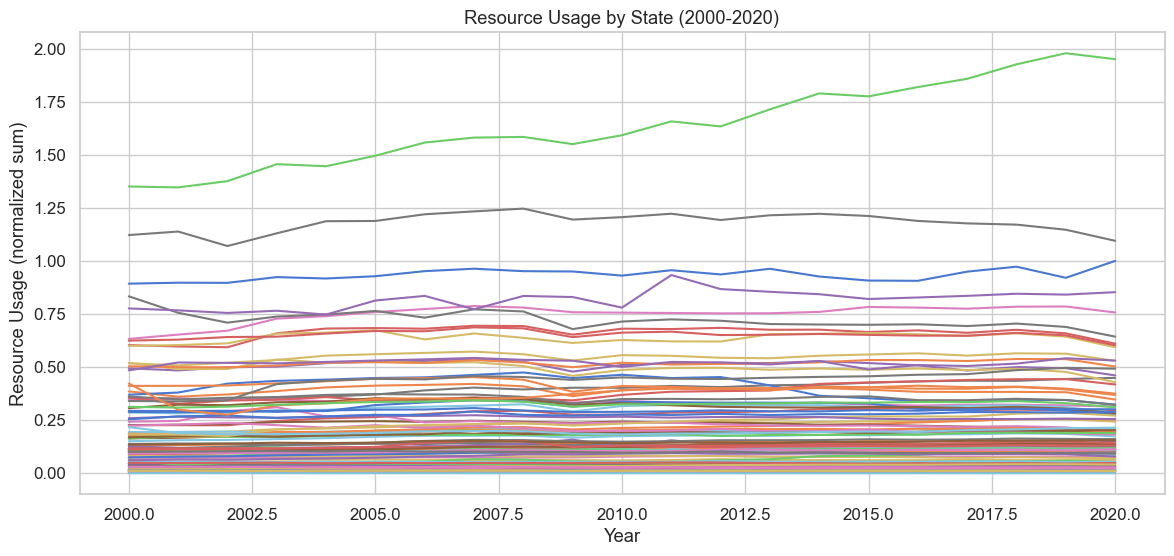

In [18]:
# simple plot all states --resource_usage over time
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))

for state in combined['state'].unique():
    state_data = combined[combined['state'] == state]
    plt.plot(state_data['year'], state_data['resource_usage'])

plt.title("Resource Usage by State (2000-2020)")
plt.xlabel("Year")
plt.ylabel("Resource Usage (normalized sum)")
plt.show()


C:\Users\admin\AppData\Local\Temp\ipykernel_37540\673950646.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  delta = combined.groupby('state').apply(lambda x: x.loc[x['year']==2020,'resource_usage'].values[0] - x.loc[x['year']==2000,'resource_usage'].values[0])


Top 8 states by resource_usage increase: ['TX', 'VA', 'FL', 'California', 'Florida', 'OK', 'ND', 'IA']


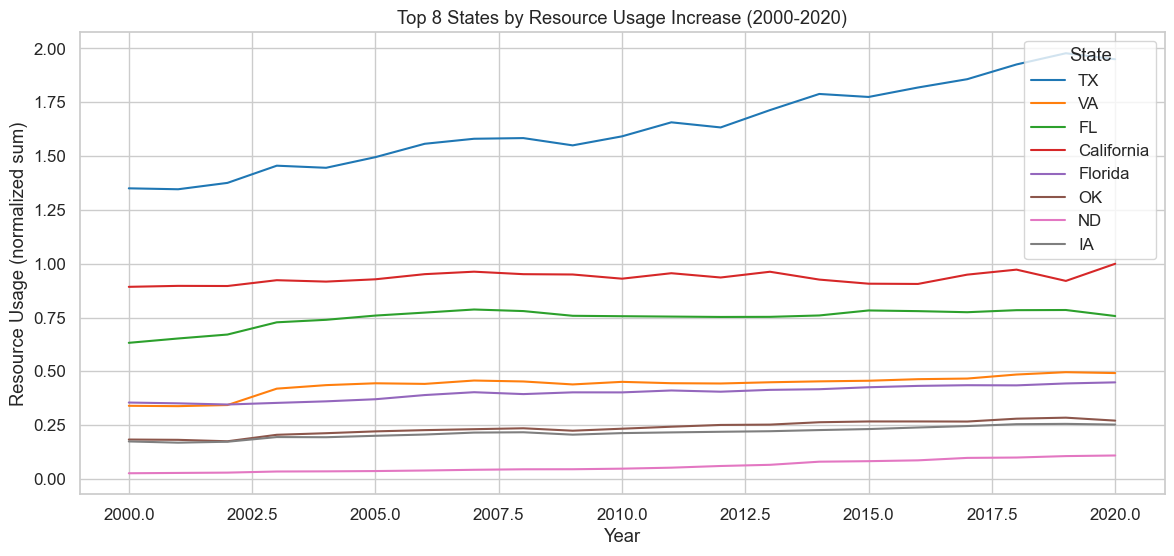

In [21]:
# compute total increase in resource_usage 2000 -> 2020
delta = combined.groupby('state').apply(lambda x: x.loc[x['year']==2020,'resource_usage'].values[0] - x.loc[x['year']==2000,'resource_usage'].values[0])

# get top 8 states by increase
top8_states = delta.sort_values(ascending=False).head(8).index.tolist()
print("Top 8 states by resource_usage increase:", top8_states)

# plot top 8 states
plt.figure(figsize=(14,6))
colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:gray']

for i, state in enumerate(top8_states):
    state_data = combined[combined['state'] == state]
    plt.plot(state_data['year'], state_data['resource_usage'], label=state, color=colors[i])

plt.title("Top 8 States by Resource Usage Increase (2000-2020)")
plt.xlabel("Year")
plt.ylabel("Resource Usage (normalized sum)")
plt.legend(title="State")
plt.show()
